# Принятие решений в бизнесе

Интернет-магазин собрал некоторые данные. Часть из них посвящена выдвинутым гипотезам и оценке аспектов их проверки, другая часть - результаты начатого А/В тестирования.

**Данные для первой части:**

Файл `hypothesis.csv`
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

**Данные для второй части:**

Файл `orders.csv`
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.


Файл `visitors.csv`
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Задача заключается в приоритизации гипотез, а также в анализе результатов А/В-теста, на основе которых необходимо будет принять решение о судьбе проведенного теста.

Для начала следует импортировать все библиотеки, необходимые для работы с данными:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import datetime as dt

Теперь можно занести в переменные полученные от заказчика датасеты:

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

Изучим датасеты более детально:

In [3]:
pd.options.display.max_colwidth = 120
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Информация в датасетах соответствует описанной заказчиком. Единственное - можно привести названия столбцов к принятому формату.

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()

In [7]:
orders.columns = ['transaction_id','visitor_id','date','revenue','group']

Изучим размеры датасетов и наличие пропусков в данных:

In [8]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков не обнаружено, датасеты небольшие по объему.

Однако формат даты не приведен к нужному, исправим это:

In [11]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

## Часть 1. Приоритизация гипотез.

- Применим фреймворк `ICE` для приоритизации гипотез.
- Применим фреймворк `RICE` для приоритизации гипотез.

Напомню, что `ICE` расчитывается, как **`ICE = Impact * Confidence / Efforts`**

Формула для расчета `RICE` следующая: **`RICE = Reach * Impact * Confidence / Efforts`**

In [12]:
hypothesis['ice'] = round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'],2)
hypothesis['rice'] = round(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'],2)

Отсортируем датасет по убыванию фреймворка `ICE`:

In [13]:
hypothesis.sort_values(by='ice',ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Повторим то же самое для `RICE`:

In [14]:
pd.options.display.max_colwidth = 120
hypothesis.sort_values(by='rice',ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Можно заметить, что приоритизация гипотез сильно меняется, когда мы переходим от `ICE` к `RICE`. Это связано с тем, что у разных гипотез разный охват пользователей, на которых ее можно проверить, и из-за этого у гипотезы метрика `RICE` может до 10 раз превосходить значение `ICE`. Лучше ориентироваться на второй расчет, т.к. может быть такое, что предствленная гипотеза сильно повлияет на пользователей и есть уверенность в полученных значениях параметров, но при этом охват пользователей, к которым она будет применена, окажется минимальным. В таком случае это не принесет большого изменения прибыли.

## Часть 2. Анализ A/B-теста

Для начала следует убедиться, что размеры групп равны или не сильно различаются, чтобы достоверность результатов не была под сомнением.

In [15]:
visitors[visitors['group']=='A']['visitors'].sum()/visitors[visitors['group']=='B']['visitors'].sum()

0.9904842461408332

Отношение числа посетителей различается менее, чем на 1%. Это значит, что при обнаружении различий в среднем чеке или числе заказов можно будет отбросить мысли о том, что это может случиться из-за разных по размеру групп.

Следует проверить, нет ли пользователей, которые попали в обе группы:

In [16]:
wrong_users = orders[orders['visitor_id'].isin(orders.loc[(orders['group']=='A')&(orders['visitor_id'].isin(orders[orders['group']=='B']['visitor_id'])),'visitor_id'].unique())]
wrong_users

,transaction_id,visitor_id,date,revenue,group
2,2961555356,4069496402,2019-08-15,400,A
20,2904772834,963407295,2019-08-15,300,B
23,4252514150,351125977,2019-08-15,15185,B
24,1162046357,3234906277,2019-08-15,7555,B
26,2223239646,199603092,2019-08-15,3488,A
...,...,...,...,...,...
1182,2682156369,1668030113,2019-08-14,1290,B
1183,1458356232,963407295,2019-08-14,4940,A
1184,1329499668,2949041841,2019-08-14,10380,B
1189,4082620617,393266494,2019-08-14,31550,B


Обнаружена 181 запись с пользователями, присутствующими в обеих группах!

In [17]:
len(orders.loc[(orders['group']=='A')&(orders['visitor_id'].isin(orders[orders['group']=='B']['visitor_id'])),'visitor_id'].unique())

58

При этом в этой 181 записи присутствует 58 человек. С одной стороны, нужно эти записи удалить. С другой стороны, эти записи составляют практически пятую часть датасета orders, что довольно много. К тому же, возникнет проблема: 181 запись о заказах пропала, а вот таблица с посещениями (поскольку исправить не так просто) осталась нетронутой: информация исказится.

In [18]:
wrong_users[wrong_users['group']=='A'].shape

(89, 5)

In [19]:
wrong_users[wrong_users['group']=='B'].shape

(92, 5)

In [20]:
wrong_users[wrong_users['group']=='A']['revenue'].sum()/wrong_users[wrong_users['group']=='A'].shape[0]

8091.539325842697

In [21]:
wrong_users[wrong_users['group']=='B']['revenue'].sum()/wrong_users[wrong_users['group']=='B'].shape[0]

9117.260869565218

В целом, эта ошибка не должна сильно исказить результаты: заказы по группам распределены равномерно, а средний чек по этим некорректным заказам несколько больше в группе В. Если понадобится, будем искать решения проблемы дальше, а пока оставим, как есть.

### Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

Для начала нужно получить датасет, в котором будет вся информация по двум группам пользователей за каждый день использования интернет-магазина в совокупности для каждой из групп.

Для этого сначала получим датасет `dates_groups`, в котором сохраним уникальные значения пар *дата-группа*. После этого подсчитаем кумулятивные показатели числа покупателей, заказов и суммы заказов в `orders_agregated` и кумулятивные показатели числа посетителей в `visitors_aggregated` за каждый день для каждой группы соответственно. Затем, объединив эти два датасета по общему столбцу даты и группы получим `cumulative_data`, где будет храниться кумулятивная выручка, число покупателей, заказов и посетителей за каждый день каждой группы.

In [22]:
dates_groups = orders[['date', 'group']].drop_duplicates()

orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'transactions',
    'buyers',
    'revenue',
    'visitors',
]

In [23]:
cumulative_data.head(6)

,date,group,transactions,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803


Чтобы построить график кумулятивной выручки по группам, можно разделить `cumulative_data` на два датасета, в каждом из которых будут данные только по одной группе.

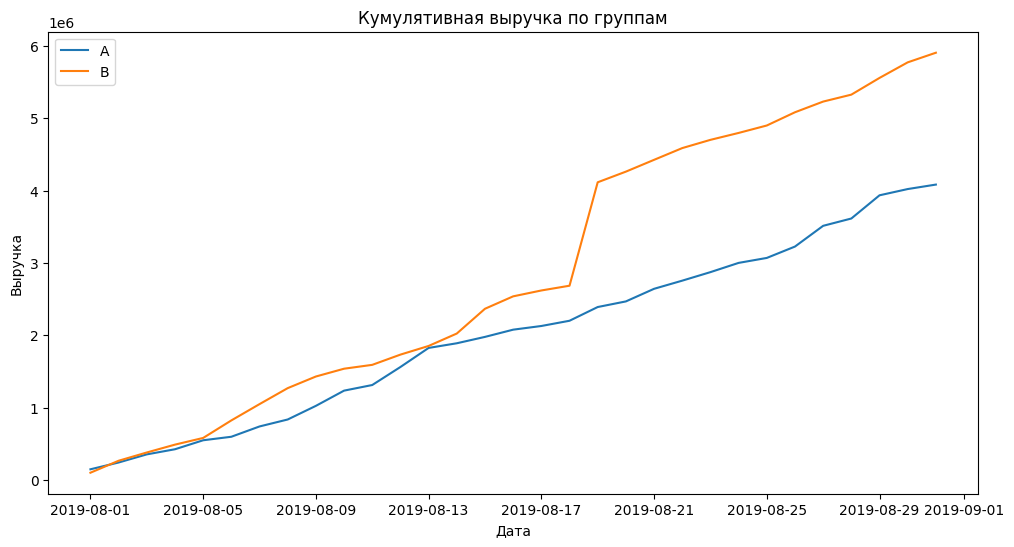

In [24]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue','transactions']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue','transactions']]
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
#plt.xticks([cumulative_revenue_a['date'].min(),cumulative_revenue_a['date'].max()])
ax.set_title('Кумулятивная выручка по группам')
ax.set_xlabel('Дата')
ax.set_ylabel('Выручка')
plt.legend();

По оси Х были оставлены только границы интервала, т.к. происходит много наложений.

Видно, что первую половину месяца кумулятивная выручка практически одинаково росла у двух групп. Скачок посередине у В свидетельствует о какой-то аномальной покупке на большую сумму, из-за чего кажется, что прибыль от группы В стала значительно выше прибыли от группы А.

### Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

Здесь новые переменные не понадобятся, т.к. вся информация уже была сохранена в предыдущем задании. Для получения среднего чека достаточно сумму покупок разделить на их число.

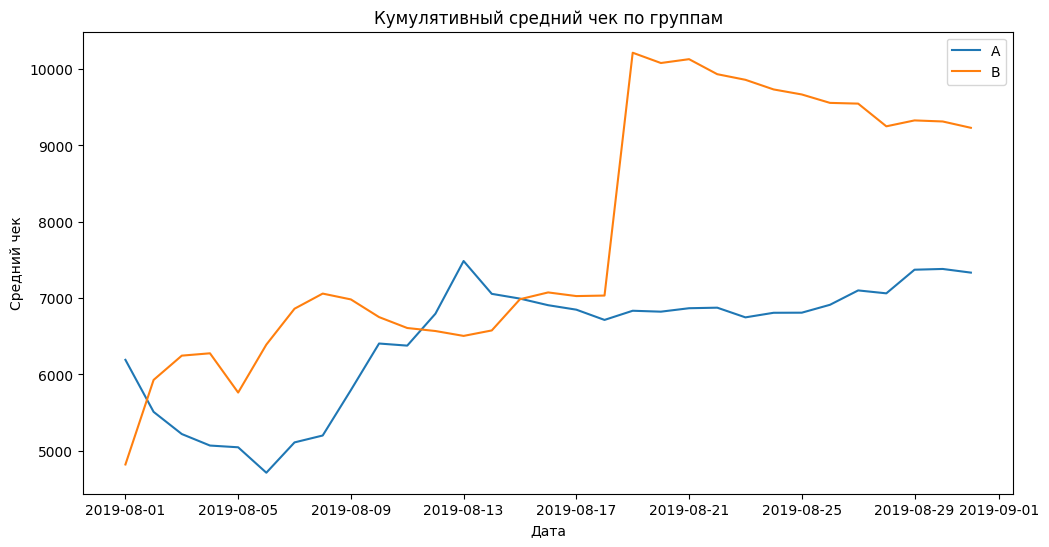

In [25]:
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['transactions'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['transactions'], label='B')
#plt.xticks([cumulative_revenue_a['date'].min(),cumulative_revenue_a['date'].max()])
ax.set_title('Кумулятивный средний чек по группам')
ax.set_xlabel('Дата')
ax.set_ylabel('Средний чек')
plt.legend();

С первых дней средний чек группы В был несколько выше, однако ближе к середине месяца средний чек группы А стал больше. Затем наблюдаем резкий скачок среднего чека в группе В, причины которого уже выяснили, и за этим скачок следует постепенное снижение среднего чека.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

Расчеты довольно просты и понятны исходя из задания. Для наглядности следует добавить горизонтальную линию в нуле, которая будет служить границей (если график выше, то средний чек В выше, и наоборот)

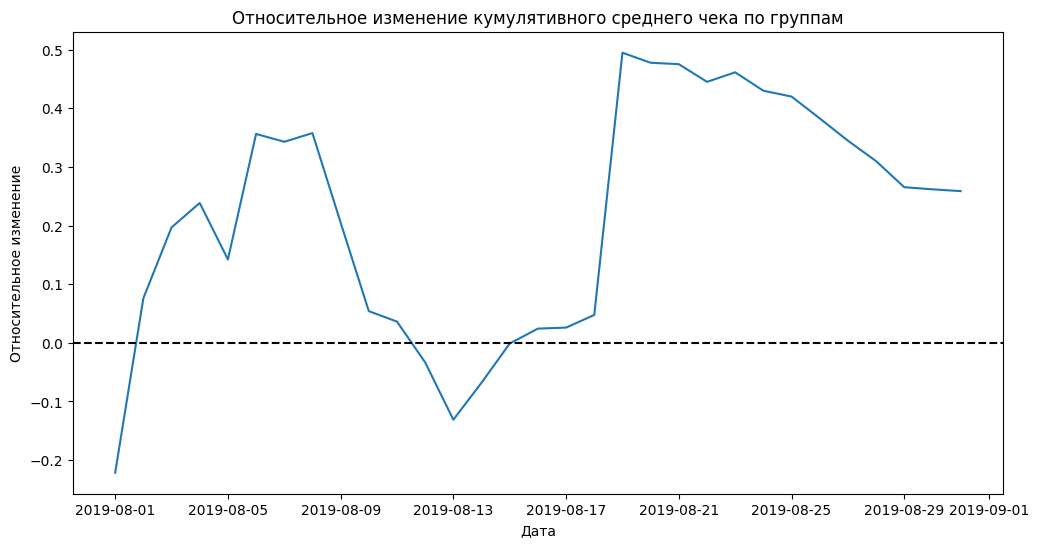

In [26]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

fig,ax=plt.subplots(figsize=(12,6))
plt.plot(merged_cumulative_revenue['date'],
         (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['transactions_b'])/
         (merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['transactions_a'])-1)

ax.set_title('Относительное изменение кумулятивного среднего чека по группам')
ax.set_xlabel('Дата')
ax.set_ylabel('Относительное изменение')
#plt.xticks([merged_cumulative_revenue['date'].min(),merged_cumulative_revenue['date'].max()])
plt.axhline(y=0, color='black', linestyle='--');

График отображает ту же информацию, что и предыдущий - в середине месяца средний чек группы А стал больше, а затем аномально большая по стоимости покупка сильно подняла средний чек группы В.

### Построим график кумулятивного среднего количества заказов по группам. Сделаем выводы и предположения.

Добавим столбец `conversion` (в рамках данной задачи будем считать, что конверсия - это отношение числа заказов к числу посетителей), в котором сохраним кумулятивное среднее число заказов по группам.

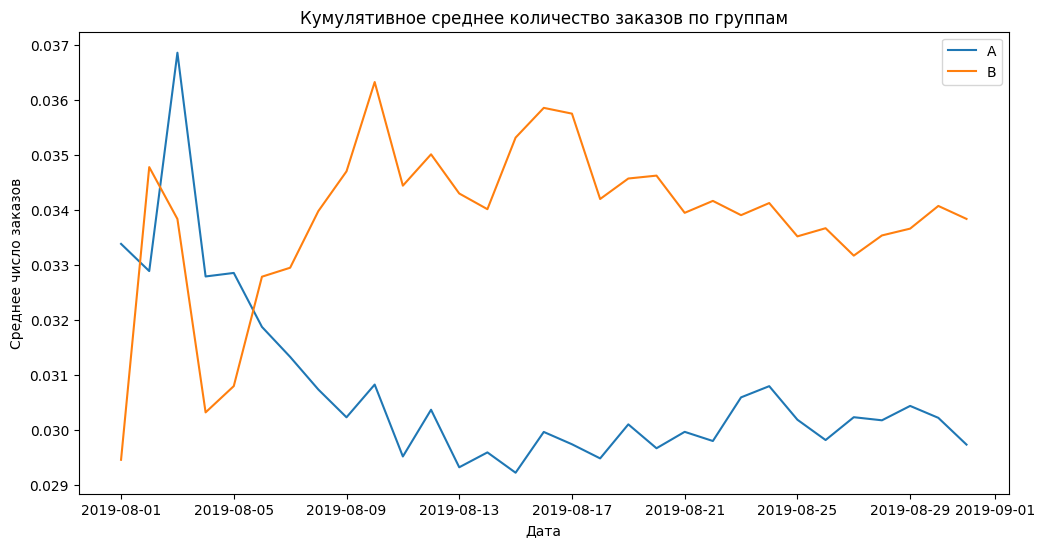

In [27]:
cumulative_data['conversion'] = cumulative_data['transactions']/cumulative_data['visitors'] 
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

fig,ax=plt.subplots(figsize=(12,6))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
#plt.xticks([merged_cumulative_revenue['date'].min(),merged_cumulative_revenue['date'].max()])

ax.set_title('Кумулятивное среднее количество заказов по группам')
ax.set_xlabel('Дата')
ax.set_ylabel('Среднее число заказов')
plt.legend();

В начале графики сильно колеблются, однако, через 10 дней среднее число заказов в группе В устанавливается около 34 заказов на 1000 пользователей против 30 заказов на 1000 пользователей в группе А.

### Построим график относительного изменения кумулятивного среднего количества заказов группы B к группе A. Сделаем выводы и предположения.

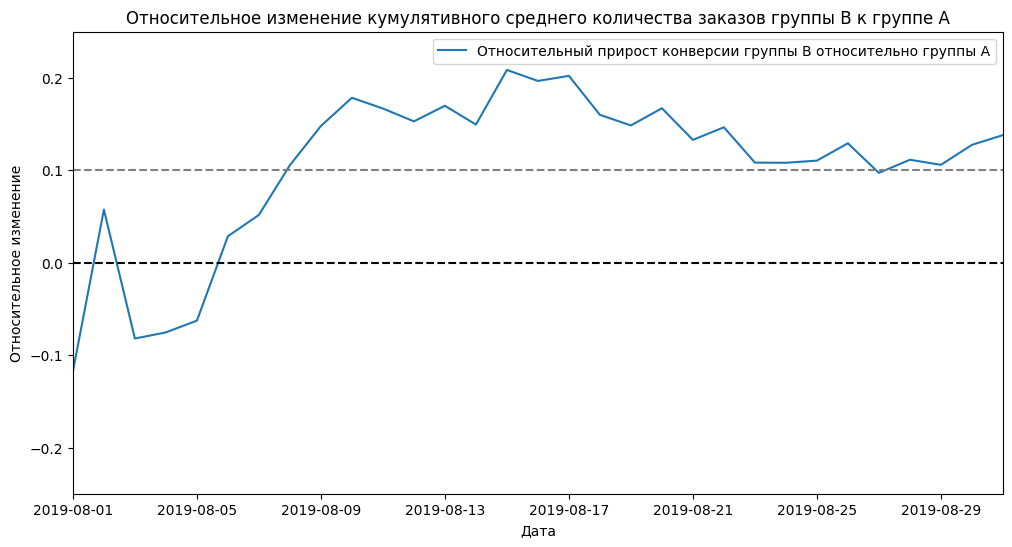

In [28]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

fig,ax=plt.subplots(figsize=(12,6))
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

ax.set_title('Относительное изменение кумулятивного среднего количества заказов группы В к группе А')
ax.set_xlabel('Дата')
ax.set_ylabel('Относительное изменение')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
#plt.xticks([merged_cumulative_conversions['date'].min(),merged_cumulative_conversions['date'].max()])
plt.axis([merged_cumulative_conversions['date'].min(),merged_cumulative_conversions['date'].max(),-0.25,0.25]);

Здесь, как и в 2.3, линия y=0 означает равенство среднего числа заказов в группах. А у=0.1, в свою очередь, добавлена для того, чтобы показать, что большую часть исследуемого периода среднее число заказов в группе В минимум на 10% выше среднего числа заказов группы А. Довольно хороший показатель.

### Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

Сначала создаем датасет с количеством заказов по пользователям:

In [29]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'transactions']

А теперь переходим к графику:

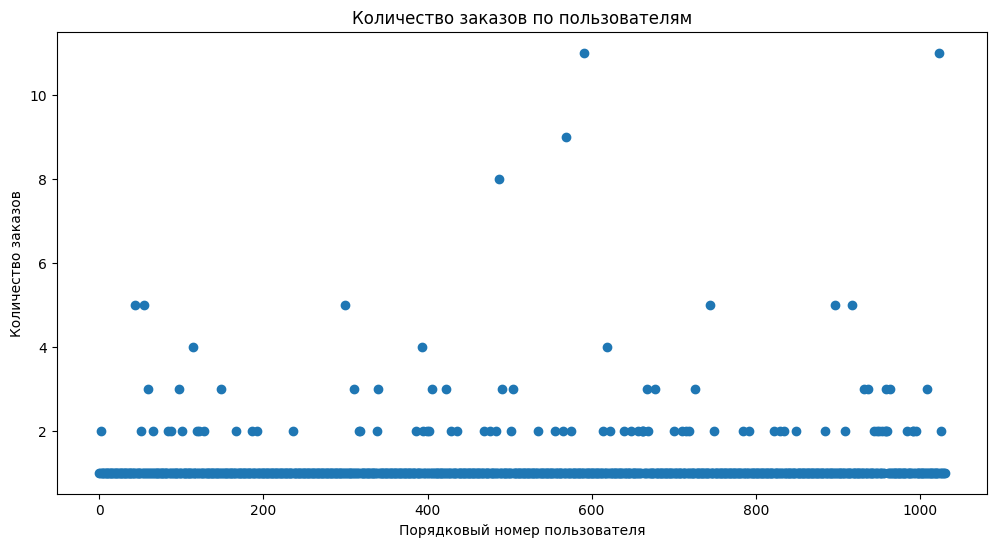

In [30]:
x_values = pd.Series(range(0, len(orders_by_users)))
fig,ax=plt.subplots(figsize=(12,6))
plt.scatter(x_values, orders_by_users['transactions'])

ax.set_title('Количество заказов по пользователям')
ax.set_xlabel('Порядковый номер пользователя')
ax.set_ylabel('Количество заказов');

Видно, что большинство пользователей совершает 1 заказ. Еще значимая часть делает 2-3 заказа, и лишь единицы совершают более 3 заказов.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [31]:
print(np.percentile(orders_by_users['transactions'], [95, 99])) 

[2. 4.]


5% пользователей делают больше 2 заказов, и лишь 1% пользователей делает больше 4. Остановимся на 3 заказах - так мы отсеим от 1 до 5% от общего числа пользователей тех, кого можно считать аномальными

### Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

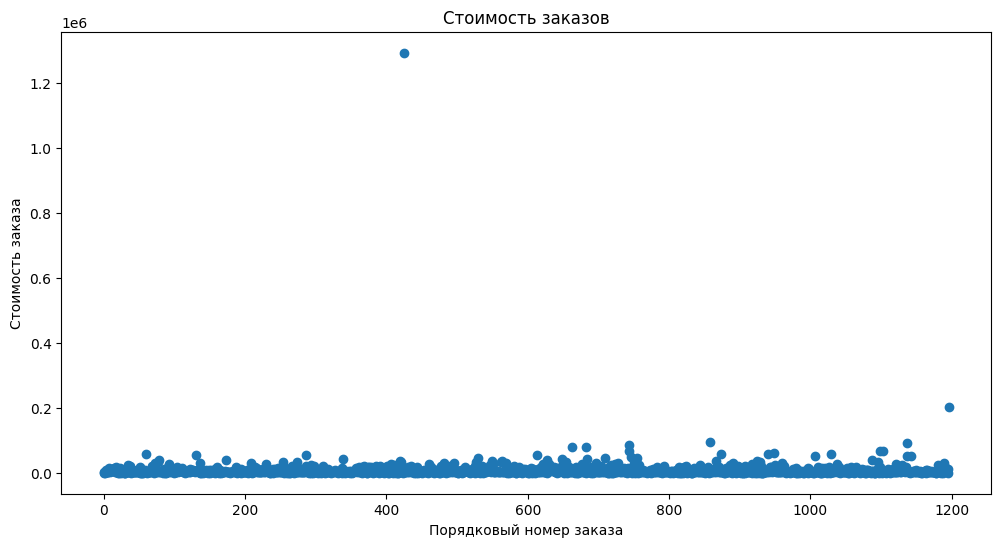

In [32]:
x_values = pd.Series(range(0, len(orders['revenue'])))
fig,ax=plt.subplots(figsize=(12,6))
plt.scatter(x_values,orders['revenue'])

ax.set_title('Стоимость заказов')
ax.set_xlabel('Порядковый номер заказа')
ax.set_ylabel('Стоимость заказа');

Действительно, как было предположено в пункте 2.1, оказался пользователь, совершивший покупку дороже миллиона!

Остальные же за раз тратят не более 50 тысяч.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [33]:
print(np.percentile(orders['revenue'],[95,99]))

[28000.  58233.2]


5% пользователей тратят более 28 тысяч, и лишь 1% более 58. Тогда возьмем границу в 40 тысяч - таким образом мы по анологии отсеим от 1 до 5% от общего числа пользователей тех, кто искажает результаты тестирования.

### Посчитаем статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. Сделаем выводы и предположения.

Для проверки статистической значимости различий следует сформулировать нулевую и альтернативную гипотезы. Нулевая всегда про равенство, а альтернативная, как правило, про неравенство.

Поэтому нулевая гипотеза будет звучать, как *среднее количество заказов между группами равно*, а альтернативная - *среднее количество заказов между группами НЕ равно*.

Также для понимания выведем, на сколько больше или меньше заказов в группе В относительно группы А.

In [34]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'transactions']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'transactions']

sample_a = pd.concat(
    [
        orders_by_users_a['transactions'],
        pd.Series(
            0,
            index=np.arange(
                cumulative_data_a['visitors'].max() - len(orders_by_users_a['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['transactions'],
        pd.Series(
            0,
            index=np.arange(
                cumulative_data_b['visitors'].max() - len(orders_by_users_b['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)

print("При уровне значимости в 5% получили p_value = {0:.5f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))

print("Различие среднего количества заказов группы В относительно группы А по сырым данным: {0:.3f}"
      .format(sample_b.mean() / sample_a.mean() - 1))

При уровне значимости в 5% получили p_value = 0.01679
Различие среднего количества заказов группы В относительно группы А по сырым данным: 0.138


p-value в 3 раза меньше уровня значимости в 5%, это говорит о том, что нулевую гипотезу о равенстве в среднем количестве заказов по "сырым" группам следует отвергнуть, и различие в 13.8% статистически значимо.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

По аналогии формулируем гипотезы. Нулевая гипотеза будет звучать, как *средний чек между группами* ***одинаков***, а альтернативная - *средний чек между группами* ***разный***.

In [35]:
print('При уровне значимости в 5% получили p_value = {0:.5f}'
      .format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Различие среднего чека группы В относительно группы А по сырым данным: {0:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

При уровне значимости в 5% получили p_value = 0.72929
Различие среднего чека группы В относительно группы А по сырым данным: 0.259


p_value больше 5%, и это говорит о том, что статистически значимого различия между средними чеками групп А и В нет, однако можно увидеть сильное влияние выброса в группе В (заказ на сумму выше миллиона) на средний чек - может показаться, что он больше, однако после фильтрации такого показателя мы уже не увидим.

### Посчитаем статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. Сделаем выводы и предположения.

Снова формулируем гипотезы. Нулевая гипотеза будет звучать, *среднее количество заказов между отфильтрованными группами равно*, а альтернативная - *среднее количество заказов между отфильтрованными группами НЕ равно*

Найдем тех самых аномальных пользователей, которых определим по выше указанным критериям (совершили больше 3 заказов или потратили более 40000 за раз):

In [36]:
users_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['transactions'] > 3]['visitor_id'],
        orders_by_users_b[orders_by_users_b['transactions'] > 3]['visitor_id'],
    ],
    axis=0,
)
users_expensive_orders = orders[orders['revenue'] > 40000]['visitor_id']
abnormal_users = (
    pd.concat([users_many_orders, users_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [37]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                cumulative_data_a['visitors'].max() - len(orders_by_users_a['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                cumulative_data_b['visitors'].max() - len(orders_by_users_b['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)
print('При уровне значимости в 5% получили p_value = {0:.5f}'
      .format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Различие среднего количества заказов группы В относительно группы А по очищенным данным: {0:.3f}'
      .format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

При уровне значимости в 5% получили p_value = 0.00931
Различие среднего количества заказов группы В относительно группы А по очищенным данным: 0.164


Можно смело делать вывод, что разница в среднем числе заказов между группой А и группой В статистически значима, при этом в группе В совершают на 16.4% заказов больше.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

По аналогии формулируем гипотезы. Нулевая гипотеза будет звучать, как *средний чек между отфильтрованными группами* ***одинаков***, а альтернативная - *средний чек между отфильтрованными группами* ***разный***.

In [38]:
orders_filtered_a = orders[np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue']
orders_filtered_b = orders[np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue']
print('При уровне значимости в 5% получили p_value = {0:.5f}'
      .format(st.mannwhitneyu(orders_filtered_a,orders_filtered_b)[1]))

print("Различие среднего чека группы В относительно группы А по очищенным данным: {0:.3f}"
      .format(orders_filtered_b.mean()/orders_filtered_a.mean()- 1))

При уровне значимости в 5% получили p_value = 0.71098
Различие среднего чека группы В относительно группы А по очищенным данным: 0.060


В данном случае очистка не изменила результатов тестирования, но зато показала реальную разницу среднего чека группы В относительно среднего чека группы А - она составляет 6%. Однако тест Манна-Уитни расчитал p-value 71.1% при уровне значимости в 5%, что говорит о невозможности отвержения нулевой гипотезы о равенстве средних чеков групп А и В.

## Вывод

По представленным заказчиком данным была проведена приоритизация гипотез и анализ результатов A/B-теста.

Что касается приоритизации гипотез, все довольно просто: лучше воспользоваться фреймворком `RICE`, т.к. он учитывает охват пользователей, участвующих в проверке гипотезы, и, чем охват выше, тем точнее и полезнее окажутся результаты.

Все гораздо интереснее с А/В-тестом. Уже при построении первого графика стало ясно, что в группе В присутствует аномально дорогой заказ, который сильно искажает все результаты по этой группе пользователей. Как было выяснено позднее, сумма заказа составила свыше одного миллиона. Соответственно, со средним чеком ситуация та же: после дня, в который совершили этот дорогой заказ, средний чек группы В постоянно будет падать, т.к. покупки обычных покупателей значительно меньше по сумме. 

Оставим пока все метрики, связанные с деньгами, до удаления аномалий, и перейдем к среднему числу заказов. В начале анализа было выяснено, что группы практически равны по размеру, а, значит, тот факт, что, исходя из графиков среднее число заказов в группе В стабильно выше среднего числа заказов в группе А минимум на 10% говорит о том, что гипотеза, проверяемая на этих группах, успешно работает в сторону повышения числа заказов. Можно подумать, что здесь тоже могли повлиять аномальные пользователи, попавшие в группу В и совершившие десятки заказов, но, спойлер - после чистки всех аномальных пользователей среднее число заказов в группе В относительно группы А больше на 16.4%.

Далее были построены диаграммы рассеяния для числа заказов и суммы заказов по пользователям, а также рассчитаны 95-ый и 99-ый перцентили этих метрик. Выяснилось, что лишь 5% совершают больше 2 заказов и на суммы свыше 28000. Поэтому условиями для очистки аномалий были приняты 3 заказа и 40 тысяч. Если у какого-то пользователя больше 3 заказов или сумма покупки выше 40 тысяч, он не попадает в новую выборку.

После этого был проведен непараметрический тест Манна-Уитни для выборок до и после фильтрации. Сравнивались средние чеки и среднее число заказов. *Ключевая идея — проранжировать две выборки по порядку от меньшего к большему и сравнить ранги одних и тех же значений, попавших в обе выборки. Ранг — это место в упорядоченной выборке. Разница между рангами одних и тех же значений может быть одинакова, и такой сдвиг называют типичным. Значит, просто добавились значения, сдвинувшие все остальные.
А нетипичные сдвиги по рангу рассматриваются как изменения. Сумма рангов таких сдвигов и выступает значением критерия. Чем он выше — тем больше вероятность, что для этих выборок интересующая нас величина различается.*

Получили следующее:
- Средний чек:
-- До фильтрации p-value=0.72929. Средний чек группы В превосходит средний чек группы А на 25.9%
-- После фильтрации - p-value=0.71098. Средний чек группы В превосходит средний чек группы А на 6% 
- Среднее число заказов
-- До фильтрации p-value=0.01679. Среднее число заказов группы В превосходит среднее число заказов группы А на 13.8%
-- После фильтрации p-value=0.00931 Среднее число заказов группы В превосходит среднее число заказов группы А на 16.4%

Это значит, что при любом уровне значимости (1,5,10%) нулевая гипотеза о равенстве средних чеков не отвергается с вероятностью более 70%. А вот гипотеза о равенстве среднего числа заказов двух групп при уровне значимости 5% отвергается, а после фильтрации отвергается и при уровне значимости в 1%. Это говорит о том, что среднее число заказов в группе В определенно выше, чем в группе А.

Раз средний чек не изменился, то, скорее всего, тест был нацелен именно на повышение среднего числа заказов. Может возникнуть вопрос: почему у группы В до и после фильтрации средний чек выше, при этом такое большое значение p-value. Ответ кроется в критериях фильтрации. Если их изменить (например, ограничиться покупками не дороже 30000), то, скорее всего, средние чеки групп сравняются.

Еще один важный момент перед заключением - важно понимать специфику продукта и время принятия решения о приобритении. Учитывая, что 95% пользователей купили товары не дороже 28000, интернет-магазин продаёт что-то повседневное и не требующее долгих размышлений, поэтому тест длиною в месяц вполне оправдан и данных достаточно. Если бы речь шла о покупке недвижимости или автомобиля, скорее всего, месяца недостаточно, т.к. далеко не каждый готов быстро решиться расстаться с крупной суммой денег.

Какой можно сделать подытог: А/В тест был проведен с целью повышения среднего числа заказов в интернет-магазине. Что именно было сделано (изменение дизайна сайта, упрощение оформления заказа или добавление скидок) - известно заказчику, но можно сделать вывод, что это изменение положительно сказалось на количестве заказов, тест можно завершить и гипотеза о повышении среднего числа заказов подтвердилась.